In [1]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import paho.mqtt.client as mqtt
from threading import Timer
import json
from config import username, password
import seaborn as sns

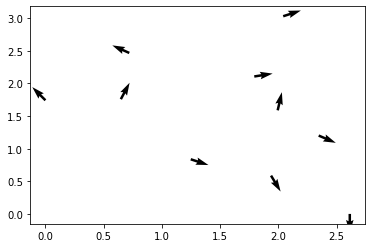

In [3]:
measured=np.array([
    [0, 37.9, 92.2, 95.2, 56.6, 95.5, 73.5, 56.7, 121.2, 73.9],
    [0, 0, 54.7, 71.8, 44.4, 59.4, 41.6, 21.9, 89.5, 46.8],
    [0, 0, 0, 60.3, 67.6, 27.3, 45.8, 42.3, 65.1, 43.5],
    [0, 0, 0, 0, 40.4, 87.1, 94.8, 78.9, 125.4, 25.4],
    [0, 0, 0, 0, 0, 86.9, 81.3, 61.5, 123.0, 28.0],
    [0, 0, 0, 0, 0, 0, 29.1, 39.1, 28.3, 67.2],
    [0, 0, 0, 0, 0, 0, 0, 20.6, 48.6, 70.0],
    [0, 0, 0, 0, 0, 0, 0, 0, 67.6, 53.5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 105.5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
measured*=0.0254
measured+=measured.T
model = MDS(n_components=2, metric=True, dissimilarity='precomputed', random_state=1, n_init=1000, max_iter=1000)
positions = model.fit_transform(measured)
positions -= positions[8]
positions[:, 1]*=-1
theta=np.radians(221)+math.atan2(positions[5,1],positions[5,0])
positions=positions.dot([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta),  np.cos(theta)]])
positions[:,0]-=positions[3,0]
angles=np.radians([18,9,-18,135,156,-59,-23,77,-90,62])
plt.quiver(positions[:,0], positions[:,1], np.cos(angles), np.sin(angles))

In [4]:
devices=pd.DataFrame(columns=("name", "address", "version", "date"))
df=pd.DataFrame(columns=("TIMESTAMP","SCANNER","ADVERTISER","TX POWER","RSSI","DISTANCE","ANGLE"))
class RepeatTimer(Timer):
    def run(self):
        while not self.finished.wait(self.interval):
            self.function(*self.args, **self.kwargs)

def switch_devices(client, devices):
    for device,payload in zip(devices["name"],np.random.choice(['scan', 'adv'],len(devices))):
        client.publish("blescan/ctrl/"+device, payload=payload)

def on_connect(client, userdata, flags, rc):
    client.subscribe("blescan/data/#")
    client.publish("blescan/ctrl", payload="who")
    client.publish("blescan/ctrl", payload="int 2")

def on_message(client, userdata, msg):
    source=msg.topic.rsplit('/', 1)[-1]
    data = json.loads(msg.payload.decode('ASCII').replace('""','"'))
    if "name" in data and data["name"] not in devices["name"].values:
        devices.loc[len(devices)]=[data["name"],data["address"],data["version"],data["date"]]
    elif "RSSI" in data and data["address"] in devices["address"].values and source in devices["name"].values:
        sc_pos=positions[int(source.replace("esp32-",""))-1]
        advertiser=devices[devices['address']==data['address']]['name'].values[0]
        ad_pos=positions[int(advertiser.replace("esp32-",""))-1]
        dx=sc_pos[0]-ad_pos[0]
        dy=sc_pos[1]-ad_pos[1]
        df.loc[len(df)]=[pd.Timestamp.now(),source,advertiser,data["txPwr"],data["RSSI"],math.sqrt(dx**2+dy**2),(math.atan2(dy,dx)-angles[int(advertiser.replace("esp32-",""))-1]+2*np.pi)%(2*np.pi)]

client=mqtt.Client("reader")
client.on_connect = on_connect
client.on_message = on_message
client.connect('mqtt.vonk', 1883)
client.username_pw_set(username=username,password=password)
timer = RepeatTimer(60, switch_devices, args=(client,devices))
try:
    client.loop_start()
    timer.start()
except KeyboardInterrupt:
    client.loop_stop()
    timer.cancel()

In [340]:
d=df.copy()
d['TIMESTAMP']=pd.to_datetime(d['TIMESTAMP'],errors='coerce')
d['SCANNER']=d['SCANNER'].astype(str)
d['ADVERTISER']=d['ADVERTISER'].astype(str)
d['TX POWER']=pd.to_numeric(d['TX POWER'],errors='coerce').astype('int8')
d['RSSI']=pd.to_numeric(d['RSSI'],errors='coerce').astype('int8')
d['DISTANCE']=pd.to_numeric(d['DISTANCE'],errors='coerce')
d['ANGLE']=pd.to_numeric(d['ANGLE'],errors='coerce')
angle_shift=(1-np.cos(2*d['ANGLE']))/d['ANGLE']*3-0.855
d['HUMAN PREDICTION']=10**((11.5511+d['TX POWER']-d['RSSI']-angle_shift)/10/2)
d['HUMAN PREDICTION']=pd.to_numeric(d['HUMAN PREDICTION'],errors='coerce')
d['HUMAN SLE']=np.log((d['DISTANCE']+1)/(d['HUMAN PREDICTION']+1))**2
d['HUMAN SLE']=pd.to_numeric(d['HUMAN SLE'],errors='coerce')

Received 6.8513 messages per second.
Human distance and angle mean squared log error is 0.30689.


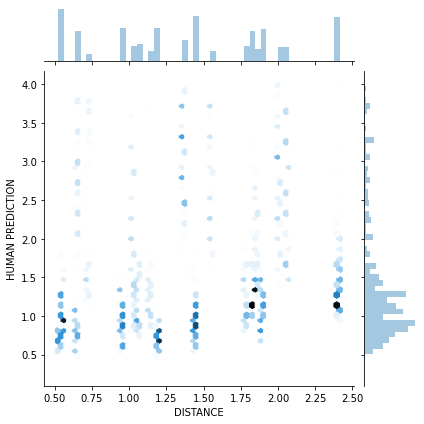

In [367]:
print('Received {0:.5} messages per second.'.format(len(df)/(df.iloc[-1]["TIMESTAMP"]-df.iloc[0]["TIMESTAMP"]).total_seconds()))
print("Human distance and angle mean squared log error is {0:.5}.".format(np.sum(d['HUMAN SLE'])/len(d)))
plot_data=d.query('`HUMAN PREDICTION`>0 and `HUMAN PREDICTION`<4')
sns.jointplot(x="DISTANCE", y="HUMAN PREDICTION", data=plot_data, kind="hex")

In [360]:
d['DISTANCE PREDICTION']=10**((11.5511+d['TX POWER']-d['RSSI'])/10/2)
d['DISTANCE PREDICTION']=pd.to_numeric(d['DISTANCE PREDICTION'],errors='coerce')
d['DISTANCE SLE']=np.log((d['DISTANCE']+1)/(d['DISTANCE PREDICTION']+1))**2
d['DISTANCE SLE']=pd.to_numeric(d['DISTANCE SLE'],errors='coerce')

Distance-only mean squared log error is 0.35679.


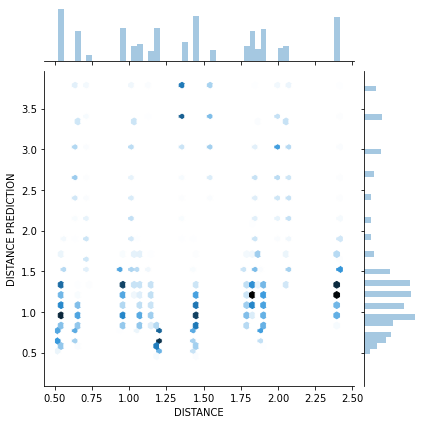

In [368]:
print("Distance-only mean squared log error is {0:.5}.".format(np.sum(d['DISTANCE SLE'])/len(d)))
plot_data=d.query('`DISTANCE PREDICTION`>0 and `DISTANCE PREDICTION`<4')
sns.jointplot(x="DISTANCE", y="DISTANCE PREDICTION", data=plot_data, kind="hex")

In [344]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [345]:
power=10**((11.5511+d['TX POWER']-d['RSSI'])/20)
cos_2angle=np.cos(2*d['ANGLE'])
sin_2angle=np.sin(2*d['ANGLE'])
cos_angle=np.cos(d['ANGLE'])
sin_angle=np.sin(d['ANGLE'])
X = pd.DataFrame([power,cos_2angle,sin_2angle,cos_angle,sin_angle]).T
y = np.ravel(d['DISTANCE'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [346]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [347]:
model = Sequential()
model.add(Dense(8, kernel_initializer='normal', activation='relu', input_shape=(5,)))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_logarithmic_error',
              optimizer='sgd',
              metrics=['mse'])
history = model.fit(X_train, y_train, epochs=24, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Train on 313526 samples, validate on 154424 samples
Epoch 1/16
313526/313526 [==============================] - 205s 653us/sample - loss: 0.0620 - mse: 0.3362 - val_loss: 0.0547 - val_mse: 0.2974
Epoch 2/16
313526/313526 [==============================] - 211s 673us/sample - loss: 0.0491 - mse: 0.2669 - val_loss: 0.0446 - val_mse: 0.2437
Epoch 3/16
313526/313526 [==============================] - 214s 683us/sample - loss: 0.0397 - mse: 0.2202 - val_loss: 0.0350 - val_mse: 0.1961
Epoch 4/16
313526/313526 [==============================] - 201s 641us/sample - loss: 0.0321 - mse: 0.1793 - val_loss: 0.0300 - val_mse: 0.1678
Epoch 5/16
313526/313526 [==============================] - 196s 624us/sample - loss: 0.0287 - mse: 0.1581 - val_loss: 0.0278 - val_mse: 0.1533
Epoch 6/16
313526/313526 [==============================] - 292s 931us/sample - loss: 0.0269 - mse: 0.1461 - val_loss: 0.0259 - val_mse: 0.1409: 5 - ETA:
Epoch 7/16
313526/313526 [==============================] - 308s 981us/sam

In [356]:
model.save('model')
model.summary()

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 8)                 48        
_________________________________________________________________
dense_49 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 9         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [348]:
X_predict=scaler.transform(X)
d['PREDICTION']=model.predict(X_predict, verbose=1)

467950/467950 [==============================] - 214s 457us/sample


In [366]:
d['DISTANCE SLE'].sum()/len(d)

0.3567858836599899

In [357]:
d['SLE']=np.log((d['DISTANCE']+1)/(d['PREDICTION']+1))**2
d.to_csv(f"pact_{d.iloc[0]['TIMESTAMP']:%Y%m%dT%H%M%S}.csv")

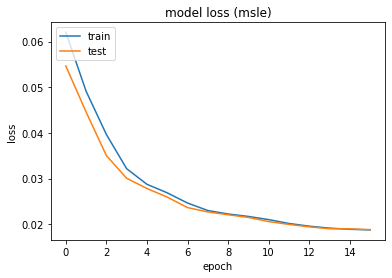

In [358]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (msle)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

ML model mean squared log error is 0.35679.


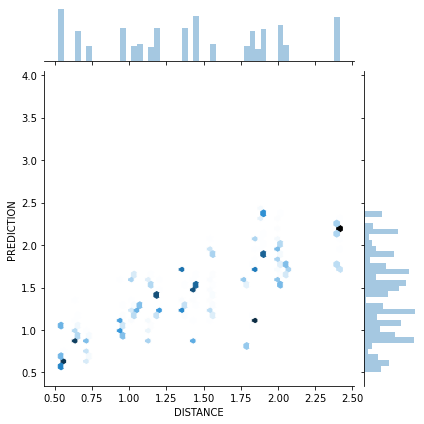

In [369]:
print("ML model mean squared log error is {0:.5}.".format(np.sum(d['DISTANCE SLE'])/len(d)))
plot_data=d.query('`PREDICTION`>0 and `PREDICTION`<4')
sns.jointplot(x="DISTANCE", y="PREDICTION", data=plot_data, kind="hex")